In [118]:
#\-- IMPORT MODULES, CLASSES AND METHODS --/#

import zipfile                          #############################
import os                               # || FILE SYSTEM / UTILS || #
import copy                             #############################
from prettytable import PrettyTable
import copy

# ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

import numpy as np                  ###################################
import pandas as pd                 # || EXPLORATIVE DATA ANALYSIS || #
import matplotlib.pyplot as plt     ###################################
import seaborn as sns
import matplotlib
# https://towardsdatascience.com/handling-missing-data-like-a-pro-part-3-model-based-multiple-imputation-methods-bdfe85f93087 NumPyro, impyute,

# ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

import sklearn
import re
import importlib
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

from sklearn import naive_bayes                         #########################
from sklearn import neural_network                      #  |-----------------|  #
from sklearn import svm                                 # || MODEL SELECTION || #
from sklearn import tree                                #  |-----------------|  #
from sklearn import linear_model                        #########################

# from PrunedCV import PrunedCV

# ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

from sklearn.model_selection import StratifiedKFold     ##########################
from sklearn.model_selection import ParameterGrid       # || MODEL VALIDATION || #
                                                        ##########################

%matplotlib inline


from bs4 import BeautifulSoup
import requests
from selenium import webdriver
import re
from datetime import datetime, timedelta

In [2]:
#\-- SET ENVIRONMENT --/#
# Before starting we need to store the data properly. We define an ad-hoc folder where we will store everything.
main_PATH = os.getcwd()

# We check whether we already have the data.                        
if 'data' not in os.listdir():                                      
                                                                    
    # Unzip files.
    with zipfile.ZipFile(r'summer_project_dataset.zip') as zip_ref:

        os.mkdir(main_PATH + '/data')   # We create the 'data' directory,
        os.chdir(main_PATH + '/data')   # we change directory,
    
        data_PATH = os.getcwd()         # we get the data path
        zip_ref.extractall(data_PATH)   # and we unzip there.       #####################
                                                                    # || FILE SYSTEM || #    
    file_PATH = data_PATH + '/summer_project_dataset'               #####################

else:

    # We just build the paths.
    data_PATH = main_PATH + '/data'
    file_PATH = data_PATH + '/summer_project_dataset'

# Finally, we go back to our main path.
os.chdir(main_PATH)

# ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# We also set a seed for reproducibility purposes.      #####################
SEED = 42                                               # || RANDOM SEED || #
np.random.seed(SEED)                                    #####################

# ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# LaTeX style plots.
plt.rcParams['figure.figsize'] = (12, 8)
# plt.rcParams['text.usetex']    = True         ############################
# plt.rcParams['font.family']    = 'serif'      # || DEFAULT PARAMETERS || #
# plt.rcParams['font.size']      = '10'         ############################

pd.set_option('display.max_rows', 20)
# pd.set_option('display.max_rows', 10)

In [3]:
#\-- DATASET LOADING AND PREPROCESSING --/#
# Aome variables are stored as float, but they are actually int. Two reasons why:
#       -) nan values are considered as float --> first estimate them and then change the data type.
#       -) there are inconsistencies, especially in kw_max_min where some int values are float instead.
# for the moment just let's store everything as float, but further inspections are needed.

data_types = {
              'url' : str, 'timedelta' : int, 'shares' : int, 'data_channel' : str, 'weekday' : str, 
              
              'n_tokens_title'          : int, 'n_tokens_content'       : int, 'n_unique_tokens' : float, 'n_non_stop_words' : float,
              'n_non_stop_unique_tokens': float, 'average_token_length' : float,

              'num_hrefs' : int, 'num_self_hrefs' : int, 'num_imgs' : float, 'num_videos' : float,
              
              'kw_min_min' : float, 'kw_max_min' : float, 'kw_avg_min' : float, 'kw_min_max' : float, 'kw_max_max'   : float,
              'kw_avg_max' : float, 'kw_min_avg' : float, 'kw_max_avg' : float, 'kw_avg_avg' : float, 'num_keywords' : float,
              
              'self_reference_min_shares' : float, 'self_reference_max_shares' : float, 'self_reference_avg_sharess' : float,
              
              'LDA_00' : float, 'LDA_01' : float, 'LDA_02' : float, 'LDA_03' : float, 'LDA_04' : float,
              
              'global_subjectivity' : float, 'global_sentiment_polarity' : float, 'global_rate_positive_words' : float, 'global_rate_negative_words' : float,
              
              'rate_positive_words' : float, 'rate_negative_words' : float,
              
              'avg_positive_polarity' : float, 'min_positive_polarity' : float, 'max_positive_polarity' : float, 'avg_negative_polarity' : float,
              'min_negative_polarity' : float, 'max_negative_polarity' : float,

              'title_subjectivity' : float, 'title_sentiment_polarity' : float, 'abs_title_subjectivity' : float, 'abs_title_sentiment_polarity' : float,
              }                                                    
                                                                   
                                                                   
df = pd.read_csv(file_PATH + r'/development.csv',                 
                   usecols = lambda column: column != 'id', dtype = data_types)              
df


,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,data_channel,weekday
0,http://mashable.com/2014/09/08/safest-cabbies-...,121,12,1015,0.422018,1.0,0.545031,10,6,33.0,...,-0.160714,-0.500000,-0.071429,0.000000,0.000,0.500000,0.000,2900,bus,tuesday
1,http://mashable.com/2013/07/25/3d-printed-rifle/,532,9,503,0.569697,1.0,0.737542,9,0,NaN,...,-0.157500,-0.250000,-0.100000,0.000000,0.000,0.500000,0.000,1300,tech,thursday
2,http://mashable.com/2013/10/30/digital-dinosau...,435,9,232,0.646018,1.0,0.748428,12,3,4.0,...,-0.427500,-1.000000,-0.187500,0.000000,0.000,0.500000,0.000,17700,lifestyle,wednesday
3,http://mashable.com/2014/08/27/homer-simpson-i...,134,12,171,0.722892,1.0,0.867925,9,5,0.0,...,-0.216667,-0.250000,-0.166667,0.400000,-0.250,0.100000,0.250,1500,bus,wednesday
4,http://mashable.com/2013/01/10/creepy-robotic-...,728,11,286,0.652632,1.0,0.800000,5,2,NaN,...,-0.251786,-0.500000,-0.100000,0.200000,-0.100,0.300000,0.100,1400,tech,thursday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31710,http://mashable.com/2014/11/30/star-wars-guard...,37,11,440,0.564103,1.0,0.718978,10,2,NaN,...,-0.209167,-0.316667,-0.050000,0.000000,0.000,0.500000,0.000,1000,world,tuesday
31711,http://mashable.com/2014/11/14/uk-floods/,52,14,0,0.000000,0.0,0.000000,0,0,0.0,...,0.000000,0.000000,0.000000,0.666667,-0.700,0.166667,0.700,11000,lifestyle,monday
31712,http://mashable.com/2014/09/08/paypal-bitcoin-...,121,9,969,0.489583,1.0,0.710623,6,5,2.0,...,-0.400000,-1.000000,-0.050000,0.000000,0.000,0.500000,0.000,2400,tech,tuesday
31713,http://mashable.com/2013/08/23/mashable-androi...,503,11,1976,0.412308,1.0,0.621080,21,3,1.0,...,-0.323413,-1.000000,-0.050000,0.700000,-0.400,0.200000,0.400,6000,lifestyle,friday


# Discard outliers from shares

30929 from 31715
97.52% of observations retained.


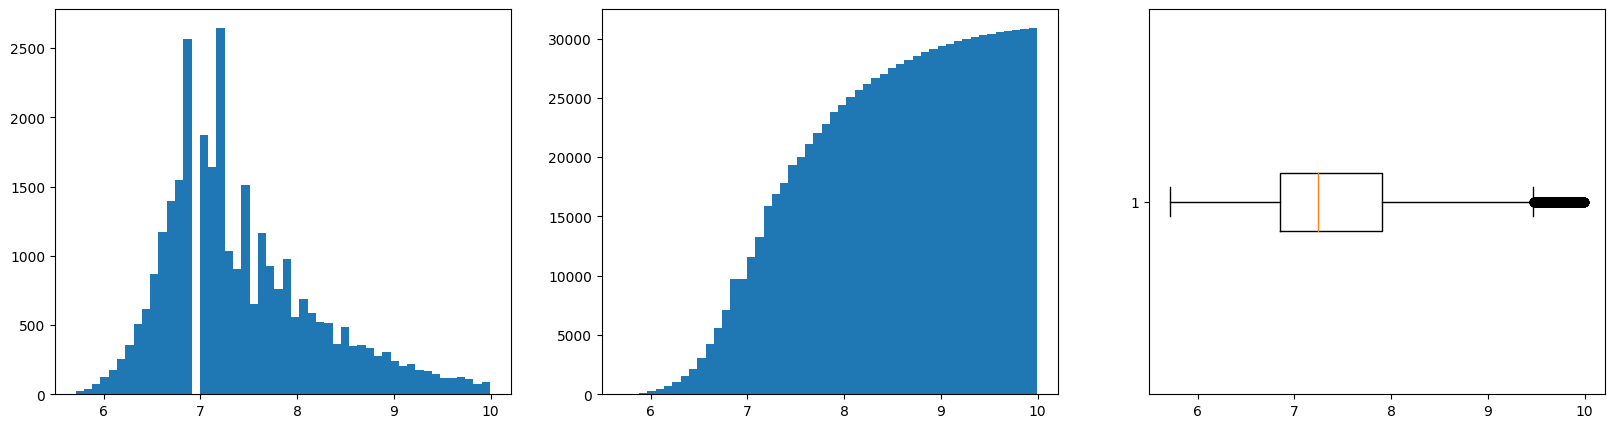

In [4]:
# We discard outliers using two subjective thresholds.
min = 300
max = 22000
df_filtered = df[(df['shares'] < max) & (df['shares'] > min)]

fig, ax = plt.subplots(1, 3, figsize = (20, 5))

ax[0].hist(np.log(df_filtered['shares']), bins = 50)
ax[1].hist(np.log(df_filtered['shares']), bins = 50, cumulative = True)
ax[2].boxplot(np.log(df_filtered['shares']), vert = False)

print(f"{len(df_filtered['shares'])} from {len(df['shares'])}\n{len(df_filtered['shares']) / len(df['shares'])*100:.2f}% of observations retained.")


We can safely remove the most extreme observations by reducing just by a small percentage the total amount of data. We can do this because we have applied the logarithm, thus stabilizing the behaviour of the observations.

# Check correlations.

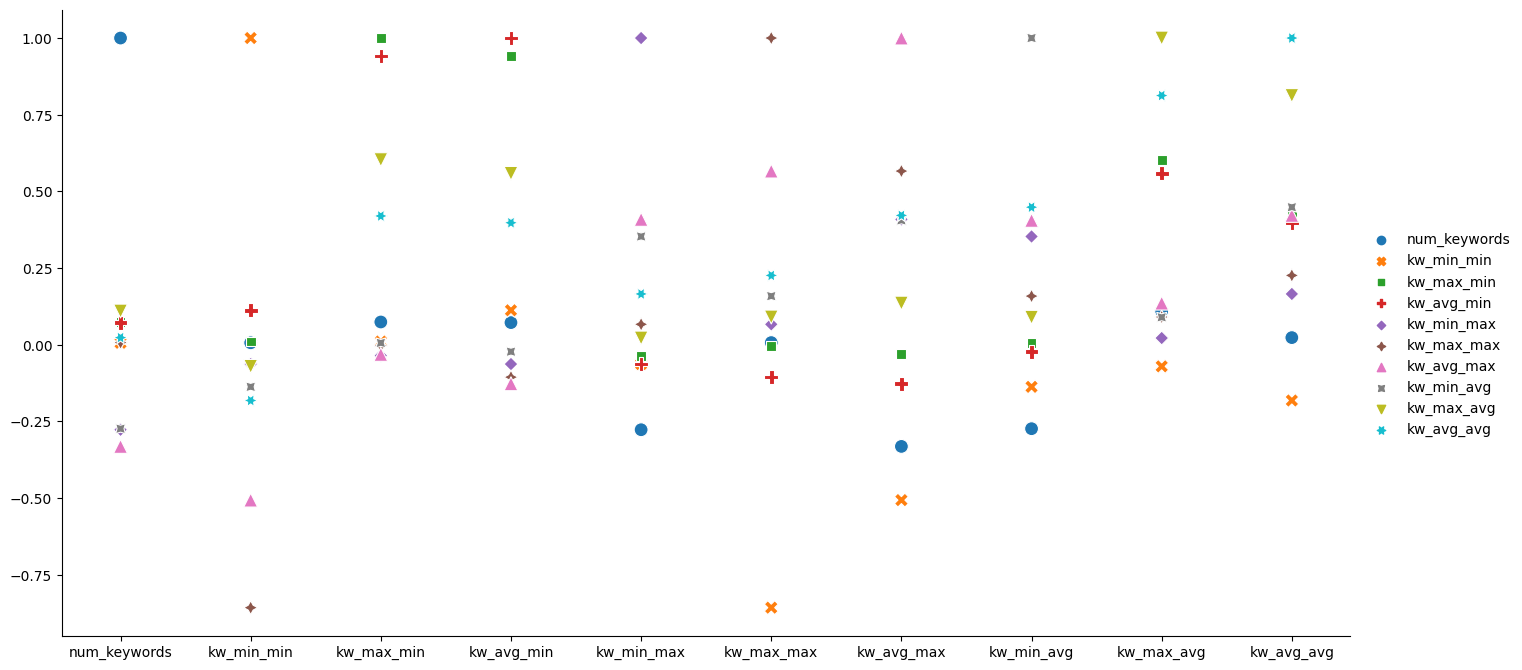

In [5]:
# Compute the linear correlation between kw.
corr_kw = df_filtered.loc[:, 'num_keywords':'kw_avg_avg'].corr()

sns.relplot(corr_kw, height = 7, aspect = 2, s = 100)


* kw_max_min strongly positively correlated to kw_avg_min > 0.90
* kw_max_avg strongly positively correlated to kw_avg_avg > 0.80
* kw_min_min strongly negatively correlated to kw_max_max < -0.80

* kw_max_min quite positively correlated to kw_kw_max_avg > 0.60
* kw_avg_min quite positively correlated to kw_kw_max_avg > 0.60
* kw_max_max quite positively correlated to kw_kw_avg_max > 0.60

We can safely discard some features. We choose to <br>

**KEEP**
* kw_avg_min 
* kw_avg_avg
* kw_max_max

**DISCARD**
* kw_max_min
* kw_max_avg
* kw_min_min

**TRANSFORM**
* kw_avg_max

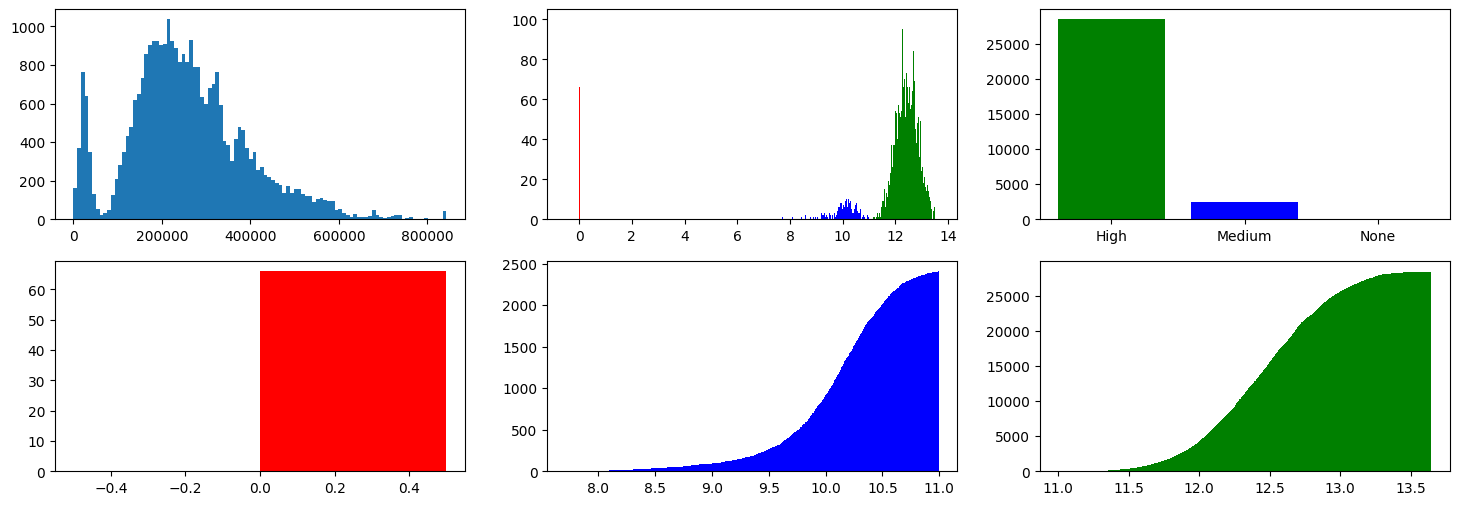

In [27]:
# We also discretize kw_avg_max. It looks like a bimodal distribution, we apply the log to stabilize more and preserve the 'None' information.
kw_filtered = copy.deepcopy(df_filtered)

conditions = [
    (np.log(kw_filtered['kw_avg_max'] + 1) < 2),
    ((np.log(kw_filtered['kw_avg_max'] + 1) < 11) & (np.log(kw_filtered['kw_avg_max'] + 1) > 0)),
    (np.log(kw_filtered['kw_avg_max'] + 1) > 11)
]

labels = ['None', 'Medium', 'High']

kw_filtered['discretized_kw_avg_max'] = np.where(conditions[0], labels[0],
                                                 np.where(conditions[1], labels[1],
                                                          np.where(conditions[2], labels[2], None)))



fig, ax = plt.subplots(2, 3, figsize = (18, 6))

ax[0, 0].hist(df_filtered['kw_avg_max'], bins = 100, cumulative = False)

ax[0, 1].hist(np.log(kw_filtered[conditions[0]]['kw_avg_max'] + 1), bins = 40, cumulative = False, color='red', label='None')
ax[0, 1].hist(np.log(kw_filtered[conditions[1]]['kw_avg_max'] + 1), bins = 1000, cumulative = False, color='blue', label='Medium')
ax[0, 1].hist(np.log(kw_filtered[conditions[2]]['kw_avg_max'] + 1), bins = 1000, cumulative = False, color='green', label='High')

ax[0, 2].bar(x = kw_filtered['discretized_kw_avg_max'].unique(), height = kw_filtered['discretized_kw_avg_max'].\
                                                                       groupby(kw_filtered['discretized_kw_avg_max']).size().values,
                                                                 color = ['green', 'blue', 'red'])

ax[1, 0].hist(np.log(kw_filtered[conditions[0]]['kw_avg_max'] + 1), bins = 70, cumulative = True, color='red', label='None')
ax[1, 1].hist(np.log(kw_filtered[conditions[1]]['kw_avg_max'] + 1), bins = 1000, cumulative = True, color='blue', label='Medium')
ax[1, 2].hist(np.log(kw_filtered[conditions[2]]['kw_avg_max'] + 1), bins = 1000, cumulative = True, color='green', label='High')

kw_filtered = kw_filtered.drop(columns = ['kw_max_min', 'kw_max_avg', 'kw_min_min', 'kw_avg_max'])

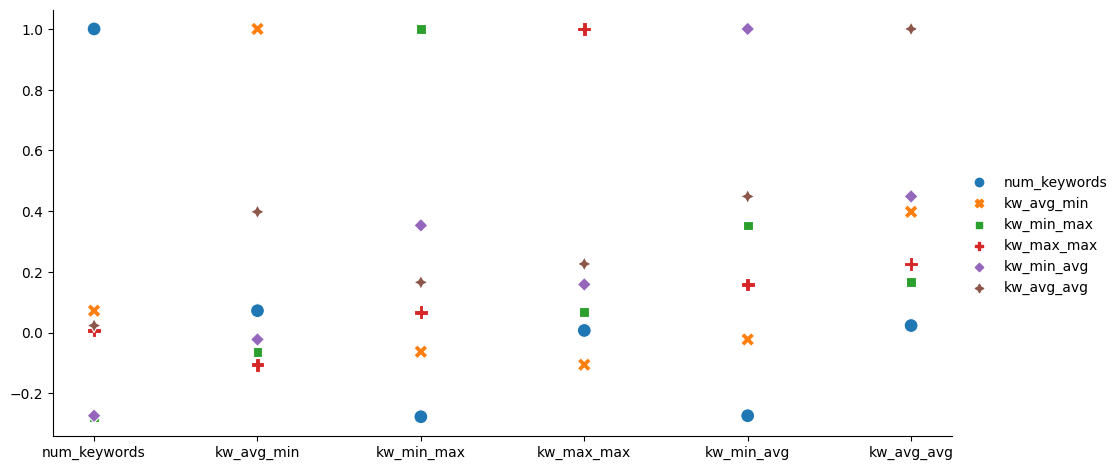

In [41]:
# No more correlations between kw variables.
sns.relplot(kw_filtered.loc[:, ['num_keywords', 'kw_avg_min', 'kw_min_max', 'kw_max_max', 'kw_min_avg', 'kw_avg_avg']].corr(), 
            height = 5, aspect = 2, s = 100)

df_filtered = copy.deepcopy(kw_filtered)

# Fill missing values, drop non predictive columns and work on weekdays

In [42]:
# url,id  and time delta are not predictive column --> drop them
df_filtered = df_filtered.drop(['url','timedelta'], axis = 1)

# fill missing values with the mean of their column
columns_to_fill = ['num_imgs', 'num_videos', 'num_keywords']

# Fill missing values with the mean
df_filtered[columns_to_fill] = df_filtered[columns_to_fill].fillna(df_filtered[columns_to_fill].mean(axis = 1))


Difference between the two means: 656



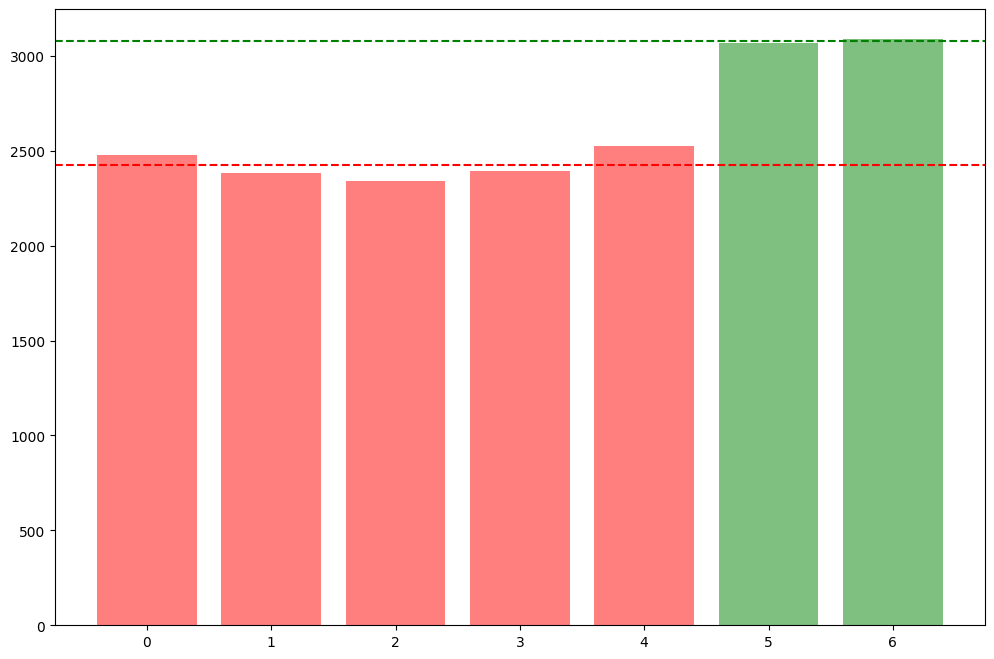

In [80]:
shares_per_day = df_filtered.groupby('weekday')['shares'].sum()
n_weekdays     = df_filtered.groupby('weekday').size()

normalized_shares_per_day = shares_per_day / n_weekdays 
plt.bar(x = normalized_shares_per_day.index, height = normalized_shares_per_day.values, color = ['red', 'red','red','red','red', 'green', 'green'], alpha = 0.5)
plt.axhline(y = normalized_shares_per_day.iloc[0:5].mean(), linestyle = "dashed", color = 'red')
plt.axhline(y = normalized_shares_per_day.iloc[5:7].mean(), linestyle = "dashed", color = 'green')

print(f'Difference between the two means: {normalized_shares_per_day.iloc[5:7].mean() - normalized_shares_per_day.iloc[0:5].mean():.0f}\n')

We can distinguish between weekend and midweek days.

In [ ]:
# Replace the values in 'weekday' column with encoded values
df_filtered['weekday'] = np.where(df_filtered['weekday'] >= 5, 'Weekend', 'Not Weekend')

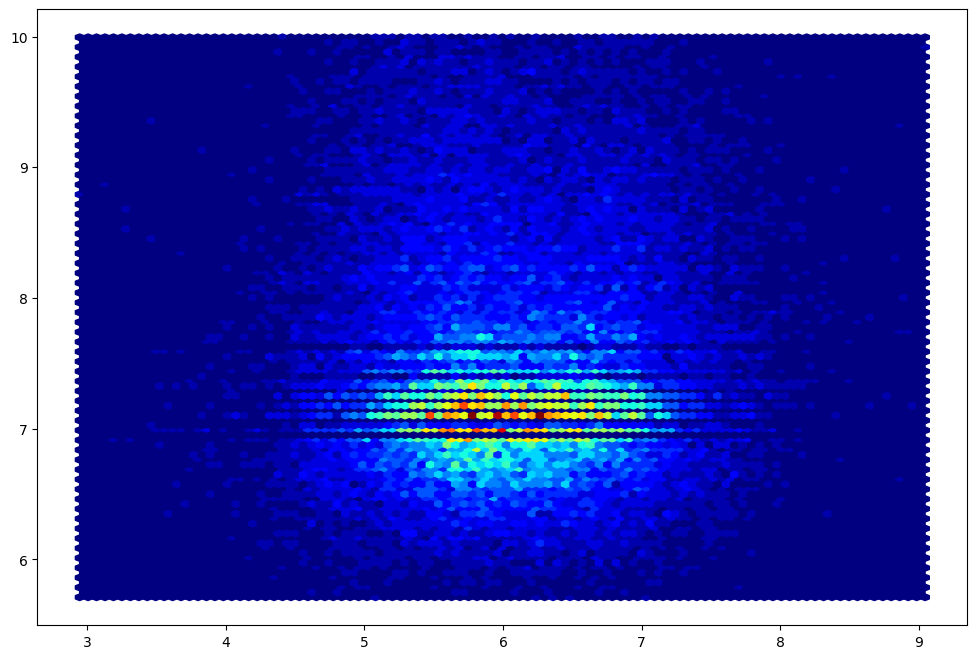

In [123]:
# a lot of values are 0 --> remove them
# df = df[df['n_tokens_content'] != 0]

(df_filtered['n_tokens_content'] == 0).sum()
plt.hexbin(x = np.log1p(df_filtered[df_filtered['n_tokens_content'] > 10]['n_tokens_content']), y = np.log(df_filtered[df_filtered['n_tokens_content'] > 10]['shares']), bins = 25, cmap=matplotlib.cm.jet)
# #drop this columns
# df = df.drop(['n_non_stop_unique_tokens','n_unique_tokens','n_non_stop_words'], axis=1)

# self_reference
# df['self_reference'] = df['self_reference_avg_sharess'] * 0.6 + df['self_reference_max_shares'] * 0.2 + df['self_reference_min_shares'] * 0.2

# df = df.drop(['self_reference_avg_sharess','self_reference_max_shares','self_reference_min_shares'],axis=1)

In [8]:
# Data_channel --> it takes only 5 values, so it will be encoded with one hot encoding
one_hot_encoded = pd.get_dummies(df['data_channel'])

# Concatenate the one-hot encoded columns with the original DataFrame
df = pd.concat([df, one_hot_encoded], axis=1)
df  = df.drop('data_channel', axis=1)

In [9]:
# a lot of values are 0 --> remove them
df = df[df['n_tokens_content'] != 0]



# #drop this columns
# df = df.drop(['n_non_stop_unique_tokens','n_unique_tokens','n_non_stop_words'], axis=1)

# self_reference
df['self_reference'] = df['self_reference_avg_sharess'] * 0.6 + df['self_reference_max_shares'] * 0.2 + df['self_reference_min_shares'] * 0.2

# df = df.drop(['self_reference_avg_sharess','self_reference_max_shares','self_reference_min_shares'],axis=1)

In [10]:
# rate_positive/ rate_negative
# look at the correlation btw these two variables with share
print('Correlation btw rate_positive_words and rate_negative_words ',df[['rate_positive_words', 'rate_negative_words', 'shares']].corr())

# rate_positive_words AND rate_negative_words are equally correlated with shares --> delete rate_negative_words
df = df.drop(['rate_negative_words'],axis=1)

Correlation btw rate_positive_words and rate_negative_words                       rate_positive_words  rate_negative_words    shares
rate_positive_words             1.000000            -0.997042  0.020932
rate_negative_words            -0.997042             1.000000 -0.020641
shares                          0.020932            -0.020641  1.000000


In [11]:
df = df.drop(['n_non_stop_unique_tokens','n_unique_tokens','n_non_stop_words'], axis=1)

In [12]:
# Find the pearson linear correlation between variables
corr_kw = df.loc[:, 'num_keywords':'kw_avg_avg'].corr()

In [13]:
corr_kw

,num_keywords,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg
num_keywords,1.000000,0.004751,0.070764,0.068665,-0.247445,0.006876,-0.302600,-0.244748,0.100747,0.021520
kw_min_min,0.004751,1.000000,0.009136,0.110933,-0.062334,-0.856924,-0.513731,-0.135668,-0.068973,-0.178279
kw_max_min,0.070764,0.009136,1.000000,0.941067,-0.034944,-0.003386,-0.031566,0.005788,0.608703,0.428439
kw_avg_min,0.068665,0.110933,0.941067,1.000000,-0.061789,-0.105015,-0.125983,-0.021571,0.564583,0.409618
kw_min_max,-0.247445,-0.062334,-0.034944,-0.061789,1.000000,0.065252,0.404041,0.350081,0.017638,0.155623
kw_max_max,0.006876,-0.856924,-0.003386,-0.105015,0.065252,1.000000,0.574335,0.156948,0.088269,0.222691
kw_avg_max,-0.302600,-0.513731,-0.031566,-0.125983,0.404041,0.574335,1.000000,0.395166,0.127059,0.397317
kw_min_avg,-0.244748,-0.135668,0.005788,-0.021571,0.350081,0.156948,0.395166,1.000000,0.086217,0.441242
kw_max_avg,0.100747,-0.068973,0.608703,0.564583,0.017638,0.088269,0.127059,0.086217,1.000000,0.817039
kw_avg_avg,0.021520,-0.178279,0.428439,0.409618,0.155623,0.222691,0.397317,0.441242,0.817039,1.000000


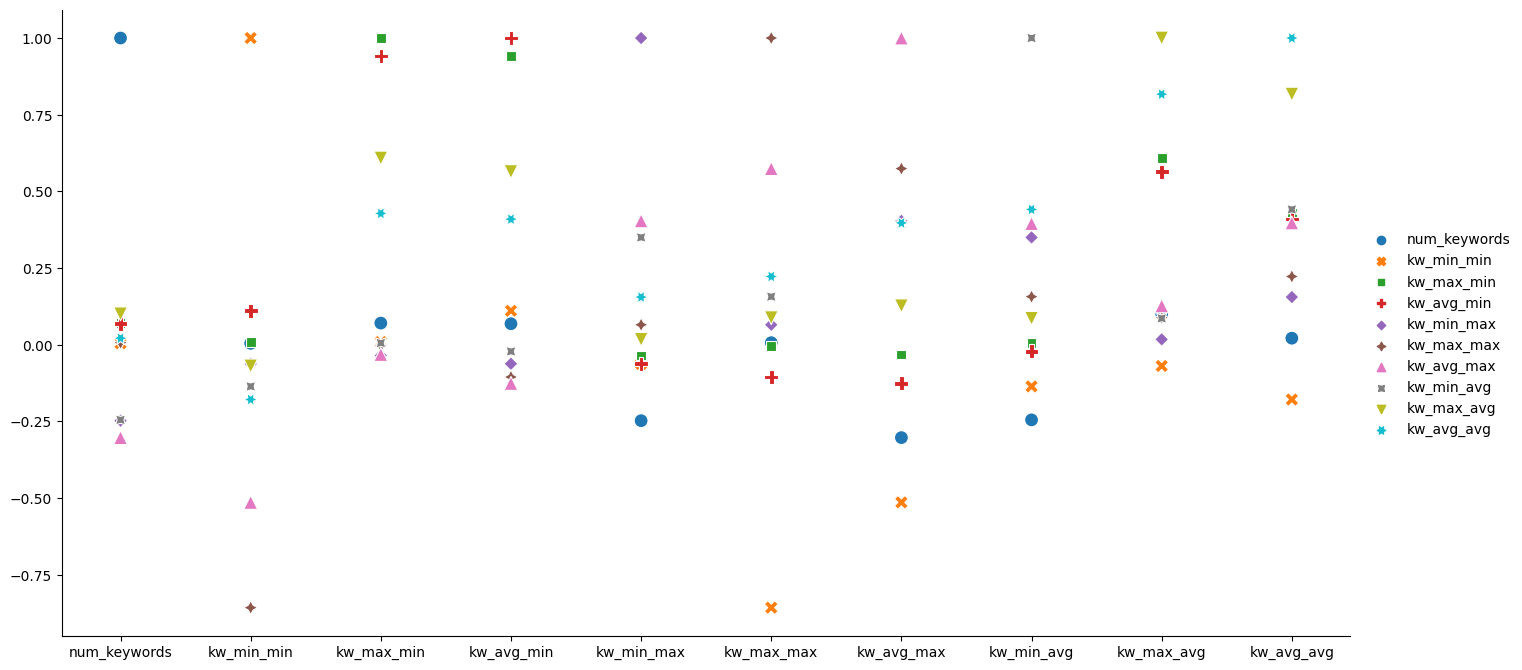

In [14]:
sns.relplot(corr_kw, height = 7, aspect = 2, s = 100)
# kw_max_min strongly positively correlated to kw_avg_min > 0.90
# kw_max_avg strongly positively correlated to kw_avg_avg > 0.80
# kw_min_min strongly negatively correlated to kw_max_max < 0.80

# kw_max_min quite positively correlated to kw_kw_max_avg > 0.60
# kw_avg_min quite positively correlated to kw_kw_max_avg > 0.60
# kw_max_max quite positively correlated to kw_kw_avg_max > 0.60

In [15]:
# plt.hist(df['kw_min_min'], bins = 100)
df['kw_worst'] = 0.6 * df['kw_avg_min'] + 0.2 * df['kw_max_min'] + 0.2 * df['kw_min_min']
df['kw_best']  = 0.6 * df['kw_avg_max'] + 0.2 * df['kw_max_max'] + 0.2 * df['kw_min_max']

<Axes: >

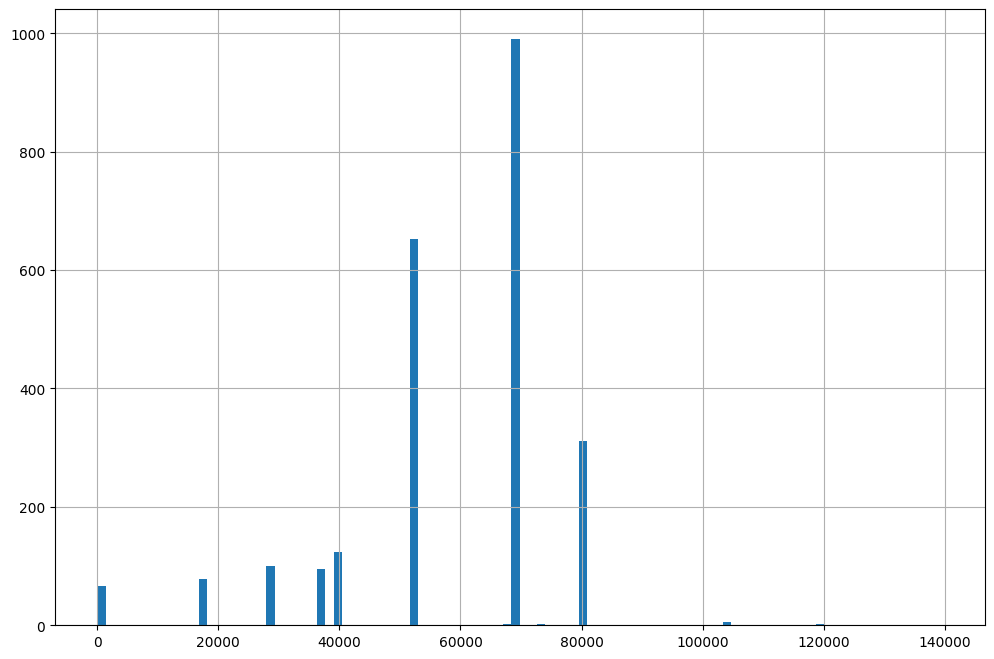

In [16]:
# Discretize kw_max_max
df[df['kw_max_max'] < 200000]['kw_max_max'].hist(bins = 100)

In [17]:
# Rimuovi outlier e tieni solo avg_min
min = 50
max = 1500
(df['kw_avg_min'] < max) & (df[df['kw_avg_min'] > min])
np.log(df[(df['kw_avg_min'] < max) & (df[df['kw_avg_min'] > min])]['kw_avg_min'] + 2).hist(bins = 100)
len(df[df['kw_avg_min'] < 1500]['kw_avg_min'])

<Axes: xlabel='kw_best', ylabel='shares'>

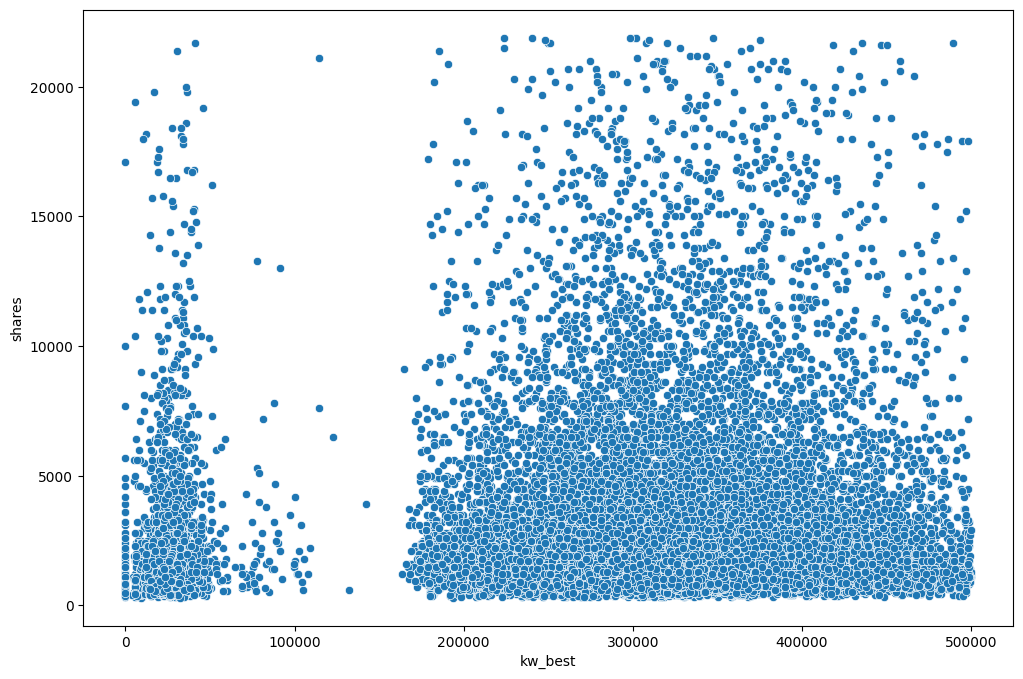

In [137]:
sns.scatterplot(x = df[df['kw_best'] < 500000]['kw_best'], y = df[df['kw_best'] < 500000]['shares'])

In [128]:
df[['kw_worst', 'kw_best', 'shares']].corr()

,kw_worst,kw_best,shares
kw_worst,1.000000,-0.301403,0.070326
kw_best,-0.301403,1.000000,0.013786
shares,0.070326,0.013786,1.000000


In [76]:

no_outliers = df[(df['shares'] < max) & (df['shares'] > min)]


(array([ 320., 1857., 5853., 7419., 5118., 3376., 2358., 1612., 1012.,
         663.]),
 array([5.71042702, 6.10029596, 6.49016491, 6.88003386, 7.26990281,
        7.65977175, 8.0496407 , 8.43950965, 8.8293786 , 9.21924754,
        9.60911649]),
 <BarContainer object of 10 artists>)

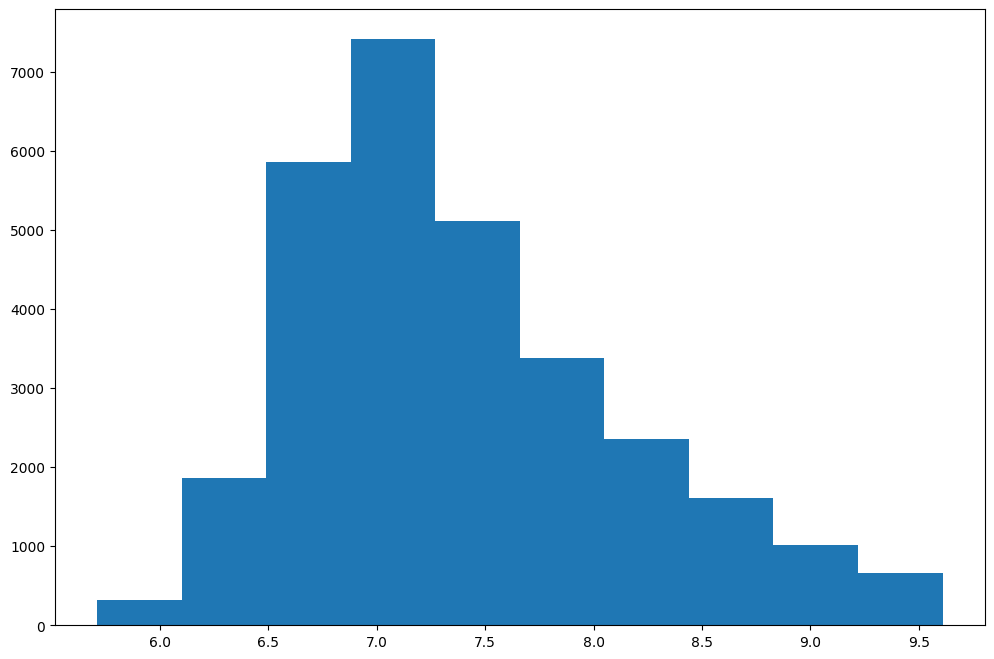

In [78]:
plt.hist(np.log(no_outliers['shares']))

In [75]:
scaled_shares.std()

1.477829414344882

<Axes: xlabel='kw_max_min', ylabel='kw_avg_min'>

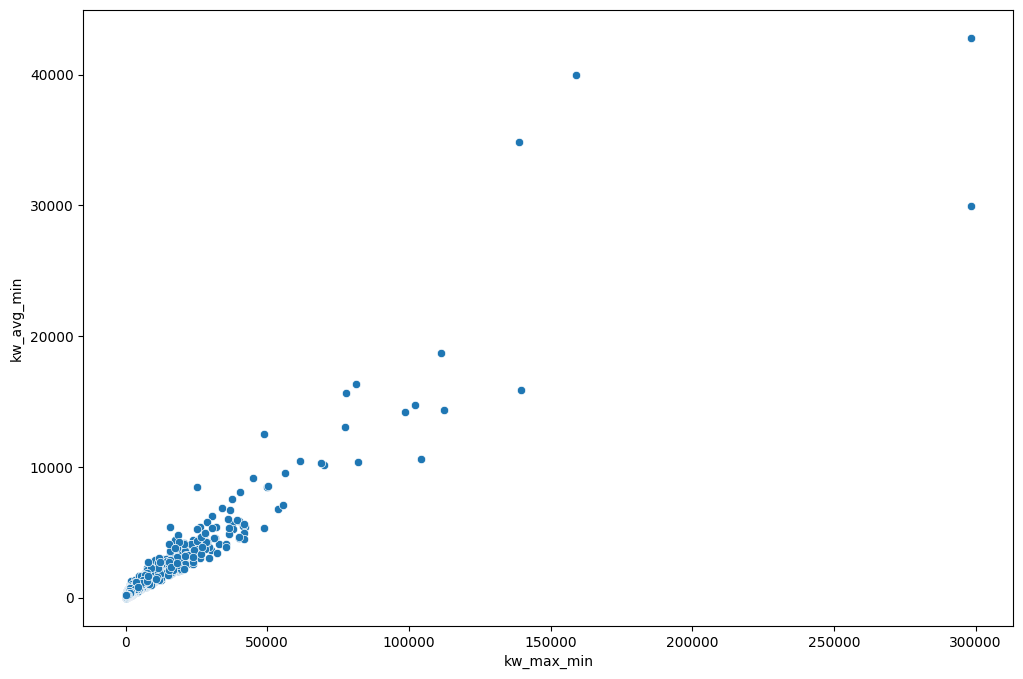

In [27]:
sns.scatterplot(x = df['kw_max_min'], y = df['kw_avg_min'])